<a href="https://colab.research.google.com/github/makikah/Time_Series_Python/blob/main/Prediction_TS_RNN_MLP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## **Notebook**
## Prediction unemployment rate using the Simple recurrent neural networks and the Multilayer perceptron-MLP for multi-step time series prediction.


In [ ]:
# Loading all the relevant libraries
from pandas import read_csv
from pandas import DataFrame
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, SimpleRNN, LSTM, GRU
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error, median_absolute_error
import math
import matplotlib.pyplot as plt

## **A base [unemployment rate] foi baixada no [link](https://fred.stlouisfed.org/series/UNRATE).**

In [ ]:
from google.colab import files
uploted = files.upload()

Saving unemployment_rate.csv to unemployment_rate.csv


# (a) Explique o mecanismo de estruturação da única série temporal em várias colunas (ou seja, várias séries temporais).

Realizar a predição de série temporal usando modelo de aprendizagem de máquina obriga a reformular a sequência de entrada **X** a um problema de aprendizado supervisionado (ou problema de regressão). O problema de aprendizado supervisionado é composto por padrões de entrada **X** e padrões de saída **y**, de modo que o modelo possa aprender como predizer os padrões de saída **y** através de padrões de entrada **X**. 

Para uma série temporal univariada é precisa criar uma ou mais colunas de observações de entrada (**t-i**) que servem como entrada e uma ou mais colunas de observações para predição (**t+i**) como saída do modelo. Esse mecanismo cria um problema de deslocamento da série. Para esse mecanismo é preciso:

---> a sequência de observações tempoarais (data).

---> time steps: o número de observações de atraso que são consideradas como entrada, isto é, $t-1,\ t-2, \dots, t-6$, como é o nosso caso.  

---> horizon: o número de observações usadas como saída do modelo ou horizonte temporal a predizer. 

Esse conjunto novo de dados é construído como um *DataFrame* com cada coluna nomeada adequadamente tanto pelo número da varíavel como pelo intervalo de tempo (célula a seguir). 

In [ ]:
# Structuring the dataset from a single time series, scaling and spliting into training / testing
def get_train_test(dataset, split_percent, time_steps, horizon):
    df = read_csv(dataset, usecols=[1], engine='python')
    data = np.array(df.values.astype('float32'))
    scaler = MinMaxScaler(feature_range=(0, 1))
    # There is a kind of data leakage in the next command
    data = scaler.fit_transform(data).flatten()
    n = len(data)
    df = DataFrame()
    for i in range(0,time_steps):
      df['t-' + str(time_steps-i-1)] = [data[j] for j in range(i, (len(data)-horizon-time_steps+i+1))]
    for i in range(1,horizon+1):
      df['t+' + str(i)] = [data[j] for j in range(time_steps+i-1, (len(data)-horizon+i))]
    print(df)
    df1 = df.copy()
    for i in range(1,horizon+1):
      df1 = df1.drop(['t+' + str(i)], axis = 1)
    dataX = np.array(df1)
    df2 = df['t+1']
    for i in range(2,horizon+1):
      df2 = pd.concat([df2, df['t+' + str(i)]], axis=1)
    datay = np.array(df2)
    # Point for splitting data into train and test
    split = int(n*split_percent)
    X = dataX[range(split),:]
    y = datay[range(split)]
    Xt = dataX[split:,:]
    yt = datay[split:]
    return X, y, Xt, yt

time_steps = 6
horizon = 4
# Here you will decide which dataset to consider.
X, y, Xt, yt = get_train_test("unemployment_rate.csv", 0.8, time_steps, horizon)
#X, y, Xt, yt = get_train_test('monthly_sunspot.csv', 0.8, time_steps, horizon)

          t-5       t-4       t-3       t-2       t-1       t-0       t+1  \
0    0.073770  0.106557  0.122951  0.114754  0.081967  0.090164  0.090164   
1    0.106557  0.122951  0.114754  0.081967  0.090164  0.090164  0.114754   
2    0.122951  0.114754  0.081967  0.090164  0.090164  0.114754  0.106557   
3    0.114754  0.081967  0.090164  0.090164  0.114754  0.106557  0.098361   
4    0.081967  0.090164  0.090164  0.114754  0.106557  0.098361  0.106557   
..        ...       ...       ...       ...       ...       ...       ...   
877  0.303279  0.286885  0.286885  0.270492  0.278689  0.237705  0.221311   
878  0.286885  0.286885  0.270492  0.278689  0.237705  0.221311  0.180328   
879  0.286885  0.270492  0.278689  0.237705  0.221311  0.180328  0.172131   
880  0.270492  0.278689  0.237705  0.221311  0.180328  0.172131  0.139344   
881  0.278689  0.237705  0.221311  0.180328  0.172131  0.139344  0.114754   

          t+2       t+3       t+4  
0    0.114754  0.106557  0.098361  
1  

# (b) Explique o papel das variáveis [time_steps] e [horizon].

---> **time_steps**: o número de atraso que precisamos para predição passo à frente, ou seja, são os passos de tempo que consideramos como entrada ao modelo. No nosso caso $t-n$, onde $n=1, 2,3,4,5,6$

---> **horizon**: é o horizonte de tempo para predição (desdobramento). Podemos dizer ainda que é o período futuro para o qual o modelo pode realizar previsões, ou seja, o número de etapas de tempo a serem preditos. No nosso caso $t+n$, onde $n=1,2,3$.

##**Implementing the simple recurrent neural network**

In [ ]:
# Execute this cell or the MLP cell below or the ESN cell below. They are mutually exclusive.
def create_RNN(hidden_units, dense_units, input_shape, activation):
    model = Sequential()
    model.add(SimpleRNN(hidden_units, activation=activation[0], input_shape=input_shape))
    model.add(Dense(units=dense_units, activation=activation[1]))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model
model = create_RNN(hidden_units=30, dense_units=horizon, input_shape=(time_steps,1), activation=['tanh', 'tanh'])
train_predict = model.fit(X, y, epochs=30, batch_size=1, verbose=2)

Epoch 1/30
712/712 - 3s - loss: 0.0035 - 3s/epoch - 4ms/step
Epoch 2/30
712/712 - 2s - loss: 0.0014 - 2s/epoch - 2ms/step
Epoch 3/30
712/712 - 2s - loss: 0.0012 - 2s/epoch - 2ms/step
Epoch 4/30
712/712 - 2s - loss: 0.0010 - 2s/epoch - 3ms/step
Epoch 5/30
712/712 - 2s - loss: 0.0011 - 2s/epoch - 3ms/step
Epoch 6/30
712/712 - 2s - loss: 9.4384e-04 - 2s/epoch - 2ms/step
Epoch 7/30
712/712 - 2s - loss: 9.6069e-04 - 2s/epoch - 3ms/step
Epoch 8/30
712/712 - 2s - loss: 9.4228e-04 - 2s/epoch - 2ms/step
Epoch 9/30
712/712 - 2s - loss: 9.4483e-04 - 2s/epoch - 2ms/step
Epoch 10/30
712/712 - 2s - loss: 9.1649e-04 - 2s/epoch - 2ms/step
Epoch 11/30
712/712 - 2s - loss: 9.4567e-04 - 2s/epoch - 3ms/step
Epoch 12/30
712/712 - 2s - loss: 9.1209e-04 - 2s/epoch - 3ms/step
Epoch 13/30
712/712 - 2s - loss: 9.0485e-04 - 2s/epoch - 2ms/step
Epoch 14/30
712/712 - 2s - loss: 8.6888e-04 - 2s/epoch - 2ms/step
Epoch 15/30
712/712 - 2s - loss: 8.7709e-04 - 2s/epoch - 2ms/step
Epoch 16/30
712/712 - 2s - loss: 8.8739

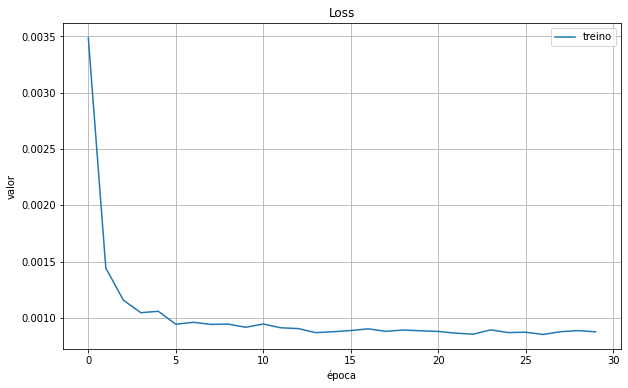

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_predict.history["loss"], label="treino")
# plt.plot(history2.history["val_loss"], label="validação")
plt.title("Loss")
plt.xlabel("época")
plt.ylabel("valor")
plt.grid()
plt.legend()
plt.show()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 30)                960       
                                                                 
 dense (Dense)               (None, 4)                 124       
                                                                 
Total params: 1,084
Trainable params: 1,084
Non-trainable params: 0
_________________________________________________________________


# (c) Explique o fluxo de informação da figura [RNN_info_flow.png], correspondente à rede neural SimpleRNN, e explique as dimensões da SimpleRNN (última célula do notebook).

A figura a seguir apresenta o desdobramento no tempo da rede RNN, com 3 instâncias, sendo que:

--> $\mathbf{x}_t$: é a entrada no tempo $t$

--> $\mathbf{h}_t$: é o estado interno (ou memória da rede) no tempo $t$, de tal forma que: $\mathbf{h}_t = w_x x_t + w_h h_{t-1}$, isso quer dizer que o estado atual é função da entrada atual $x_t$ e do estado anterior $h_{t-1}$, $f$ á a função de ativação, *tanh* no nosso casso. 

--> $\mathbf{w}_x$ e $\mathbf{w}_h$ são vetores pesos das conexões de entrada e das realimentações, respectivamente, $\mathbf{b}_h$ o vetor de polarização (bias). 

Nesta figura as 3 primeiras camadas são camadas recorrentes, desdobrado por 3 três passos de tempo e a última é a camada *feedforword*. Cada instância da rede desdobrada é compartilhada os mesmos parâmetros, e as atualizações de pesos em cada instância são somada na última camada, que têm elementos $\mathbf{w}_y$ e $\mathbf{b}_y$ vetores pesos de saída e bias, respectivamente. 


A última célula deste notebook informa sobre as dimensões da rede RNN: a rede RNN simples montada contém 1.053 parâmetros treináveis, estruturados como:

--> (1, 30): 1 entrada e 30 neurônios da camada de entrada, isso também vale por 30 pesos de $\mathbf{x}_t$;

--> (30, 30): 30 pesos das conexões das realimentações que vêm da camada de entrada para camada intermediária mais 30 neurônios que vêm da camada de entrada;

--> (30, ): 30 bias do vetor de estado;

--> (30, 3): 30 pesos (por conta de ter 30 neurônios da camada intermediária) da camada intermediária para camada de saída, junto com 3 bias de 3 horizontes;

--> (3, ): 3 bias de saídas. Contudo, o resultado da última célula do notebook reproduz as informações contidas na figura a seguir. Isso mostra na prática como nossa rede RNN simples é montada e treinada.  

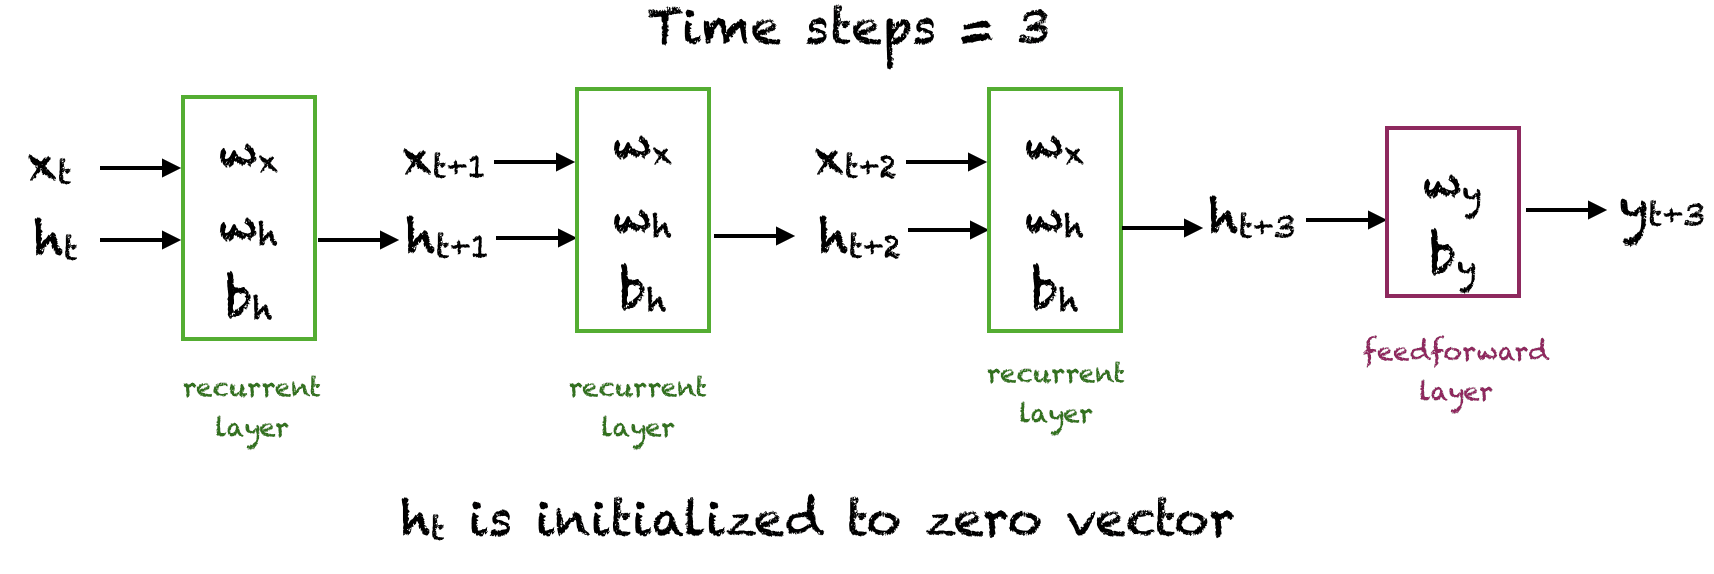

In [ ]:
# Do not run this cell or upload the PNG file and then run.
# Configuration of the simple RNN
from IPython.display import Image
Image("RNN_info_flow.png", width = 600, height = 300)

##**Implementing the MLP neural network**

In [ ]:
# Execute this cell or the RNN cell above or the ESN cell below. They are mutually exclusive.
# mean_absolute_error, mean_absolute_percentage_error
import tensorflow as tf

model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(80, activation=tf.nn.tanh),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(horizon, activation='linear')
])
model.compile(optimizer='adam', loss='mean_squared_error')
train_predict = model.fit(X, y, epochs=100)
model.summary()

Epoch 1/100
23/23 [==============================] - 1s 3ms/step - loss: 0.0163
Epoch 2/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0088
Epoch 3/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0072
Epoch 4/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0062
Epoch 5/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0050
Epoch 6/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0044
Epoch 7/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0038
Epoch 8/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0037
Epoch 9/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0034
Epoch 10/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0030
Epoch 11/100
23/23 [==============================] - 0s 2ms/step - loss: 0.0026
Epoch 12/100
23/23 [==============================] - 0s 3ms/step - loss: 0.0026
Epoch 13/100
23/23 [=================

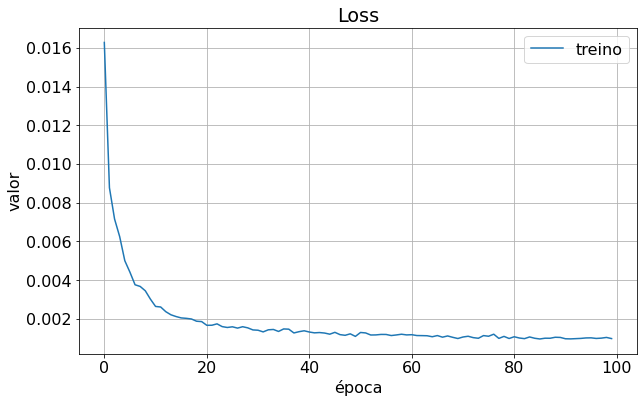

In [ ]:
plt.figure(figsize=(10,6))
plt.plot(train_predict.history["loss"], label="treino")
# plt.plot(history2.history["val_loss"], label="validação")
plt.title("Loss")
plt.xlabel("época")
plt.ylabel("valor")
plt.grid()
plt.legend()
plt.show()

##**Implementing the echo state neural network (ESN)**

In [ ]:
# Execute this cell or the RNN cell above or the MLP cell above. They are mutually exclusive.
!git clone https://github.com/cknd/pyESN.git
!cp /content/pyESN/pyESN.py .
from pyESN import ESN

Cloning into 'pyESN'...
remote: Enumerating objects: 106, done.
remote: Total 106 (delta 0), reused 0 (delta 0), pack-reused 106
Receiving objects: 100% (106/106), 1.17 MiB | 20.38 MiB/s, done.
Resolving deltas: 100% (53/53), done.


In [ ]:
model = ESN(n_inputs = time_steps,
          n_outputs = horizon,
          n_reservoir = 500,
          spectral_radius = 2,
          random_state=42)
model.fit(X,y);

# (e) Qual modelo de aprendizado (dentre as duas RNN e a MLP) levou a um melhor desempenho junto aos dados de teste?

--> Para a série de Taxa de Desemprego o modelo RNN é superior ao modelo MLP. Isso se verifica para todos os horizontes temporais. Como pode se ver que o RMSE do modelo RNN para série da Taxa de Desemprego é ligeiramente menor que a do modelo MLP. 

--> Para série de Sunspot o modelo MLP é ligeiramente superior, pois o RMSE junto aos dados de teste é relativamente menor que ao modelo RNN para esta tarefa. 

In [ ]:
from tabulate import tabulate
df = [["RNN (Taxa de desemprego)", 0.068, 0.096, 0.112], 
        ["RNN (Sunspot)", 0.082, 0.093, 0.099], 
        ["MLP (Taxa de desemprego)", 0.078, 0.110, 0.135],
      ["MLP (Sunspot)", 0.074, 0.088, 0.095]]
  
#define header names
col_names = ["DESEMPENHO DOS MODELOS", "t+1 (RMSE do teste)", "t+2 (RMSE do teste)", "t+3 (RMSE do teste)"]
  
#display table
print(tabulate(df, headers=col_names, tablefmt="fancy_grid",numalign="center"))

╒══════════════════════════╤═══════════════════════╤═══════════════════════╤═══════════════════════╕
│ DESEMPENHO DOS MODELOS   │  t+1 (RMSE do teste)  │  t+2 (RMSE do teste)  │  t+3 (RMSE do teste)  │
╞══════════════════════════╪═══════════════════════╪═══════════════════════╪═══════════════════════╡
│ RNN (Taxa de desemprego) │         0.068         │         0.096         │         0.112         │
├──────────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┤
│ RNN (Sunspot)            │         0.082         │         0.093         │         0.099         │
├──────────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┤
│ MLP (Taxa de desemprego) │         0.078         │         0.11          │         0.135         │
├──────────────────────────┼───────────────────────┼───────────────────────┼───────────────────────┤
│ MLP (Sunspot)            │         0.074         │         0.088         │         0.095 

In [ ]:
def print_error(trainY, testY, train_predict, test_predict,i):    
    # Error of predictions
    train_rmse = math.sqrt(mean_squared_error(trainY, train_predict))
    test_rmse = math.sqrt(mean_squared_error(testY, test_predict))
    # Print RMSE
    print('t+%d RMSE train: %.3f RMSE' % (i+1, train_rmse))
    print('t+%d RMSE test: %.3f RMSE' % (i+1, test_rmse))

# Make predictions
train_predict = model.predict(X)
test_predict = model.predict(Xt)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  print_error(y1, y1_t, y1_pred, y1_pred_t,i)

6/6 [==============================] - 0s 3ms/step
t+1 RMSE train: 0.020 RMSE
t+1 RMSE test: 0.075 RMSE
t+2 RMSE train: 0.025 RMSE
t+2 RMSE test: 0.111 RMSE
t+3 RMSE train: 0.031 RMSE
t+3 RMSE test: 0.134 RMSE
t+4 RMSE train: 0.038 RMSE
t+4 RMSE test: 0.153 RMSE


# (d) Execute o notebook [PC1_Ativ6_RNN_MLP_ESN_TS.ipynb] para os dois casos de estudo, tomando RNN simples, ESN e MLP (6 execuções). Apresente os resultados apenas de uma dessas execuções.

Apresentamos aqui os resultados do modelo RNN simples ao conjunto de dados sobre a Taxa de Desemprego. A primeira célula a seguir apresenta os resultados das predições geradas pelo modelo RNN simples para base de dados da Taxa de Desemprego junto aos conjuntos de dados de treinamento e de teste, também com os três horizontes temporais. 

A segunda célula a seguir apresenta os resultados do erro junto aos conjuntos de dados de treinamento e teste para série da Taxa de Desemprego. É o mesmo modelo RNN simples. 

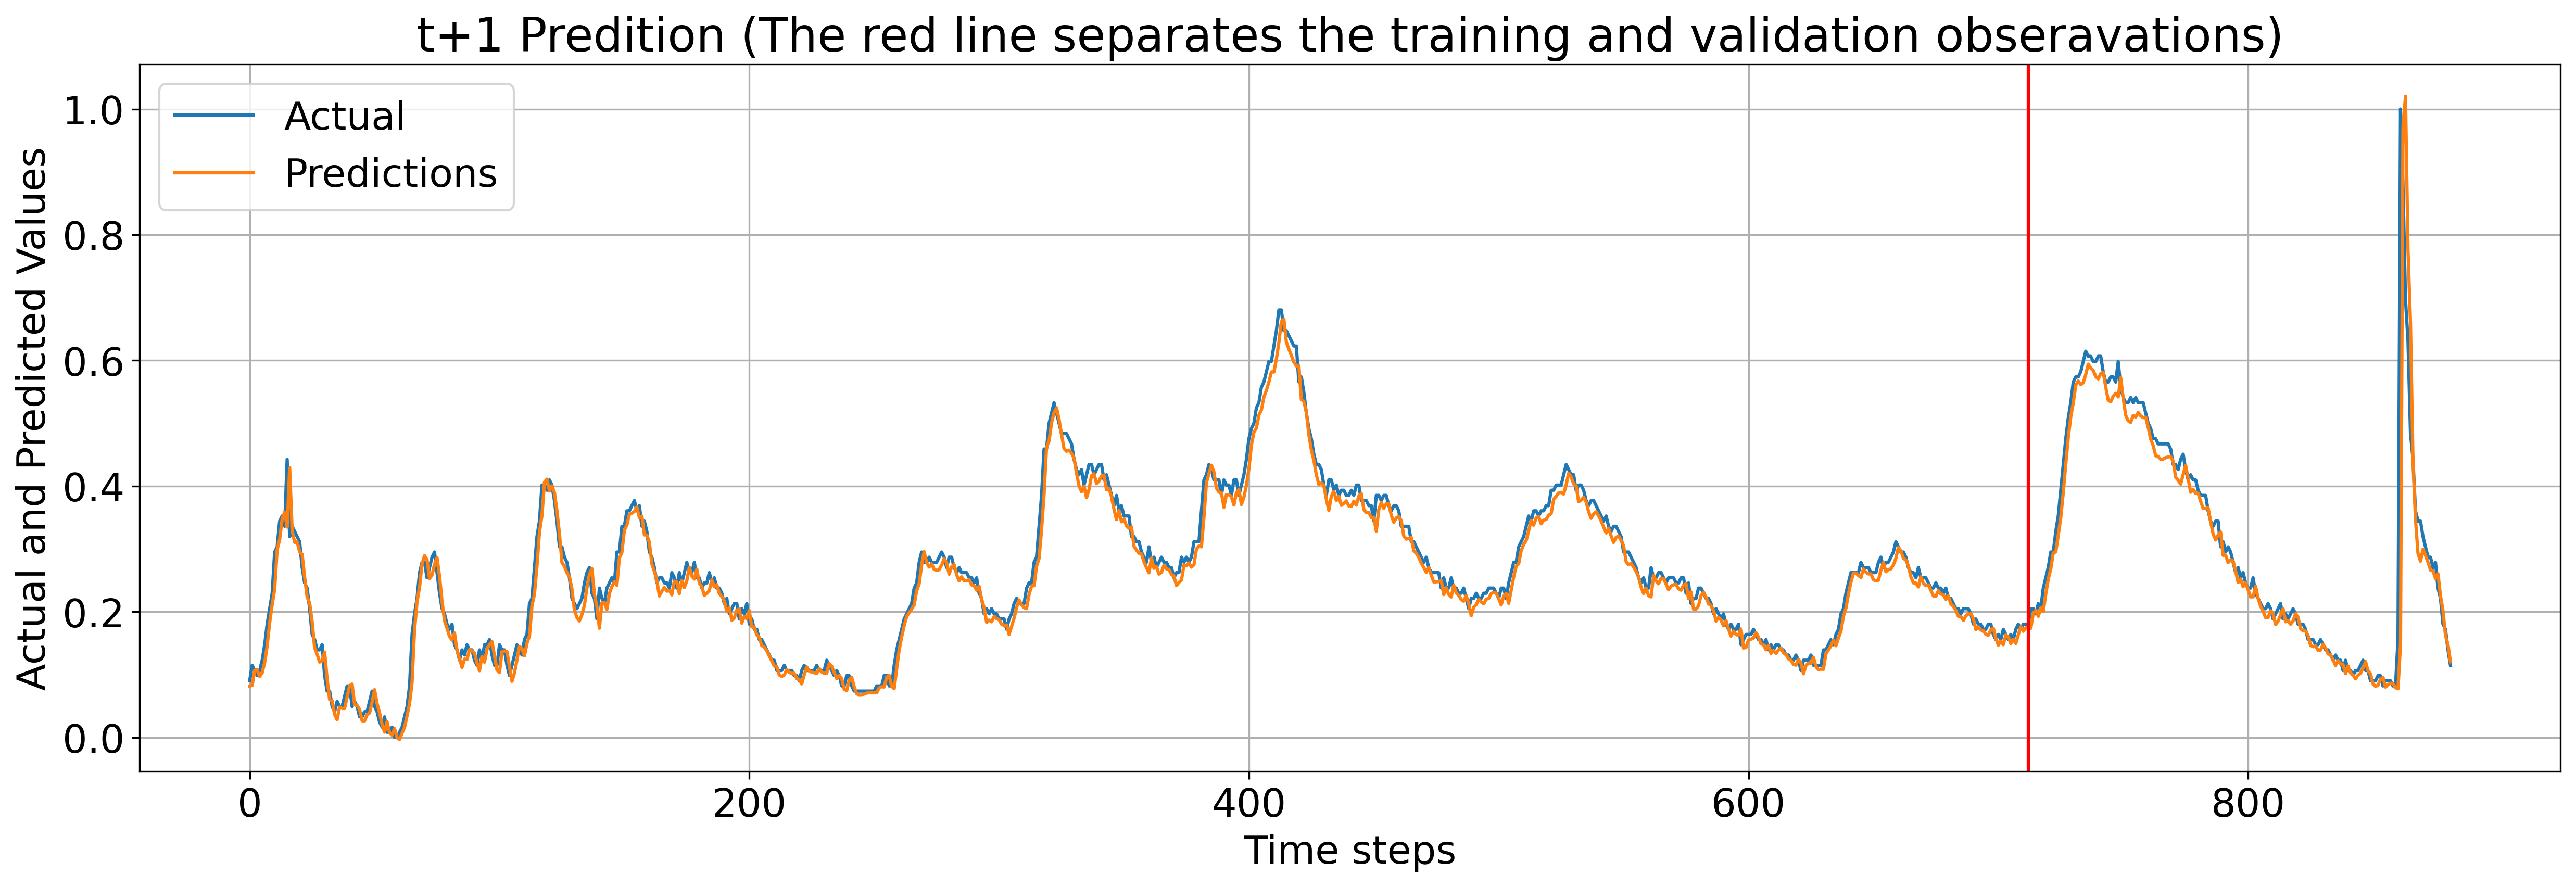

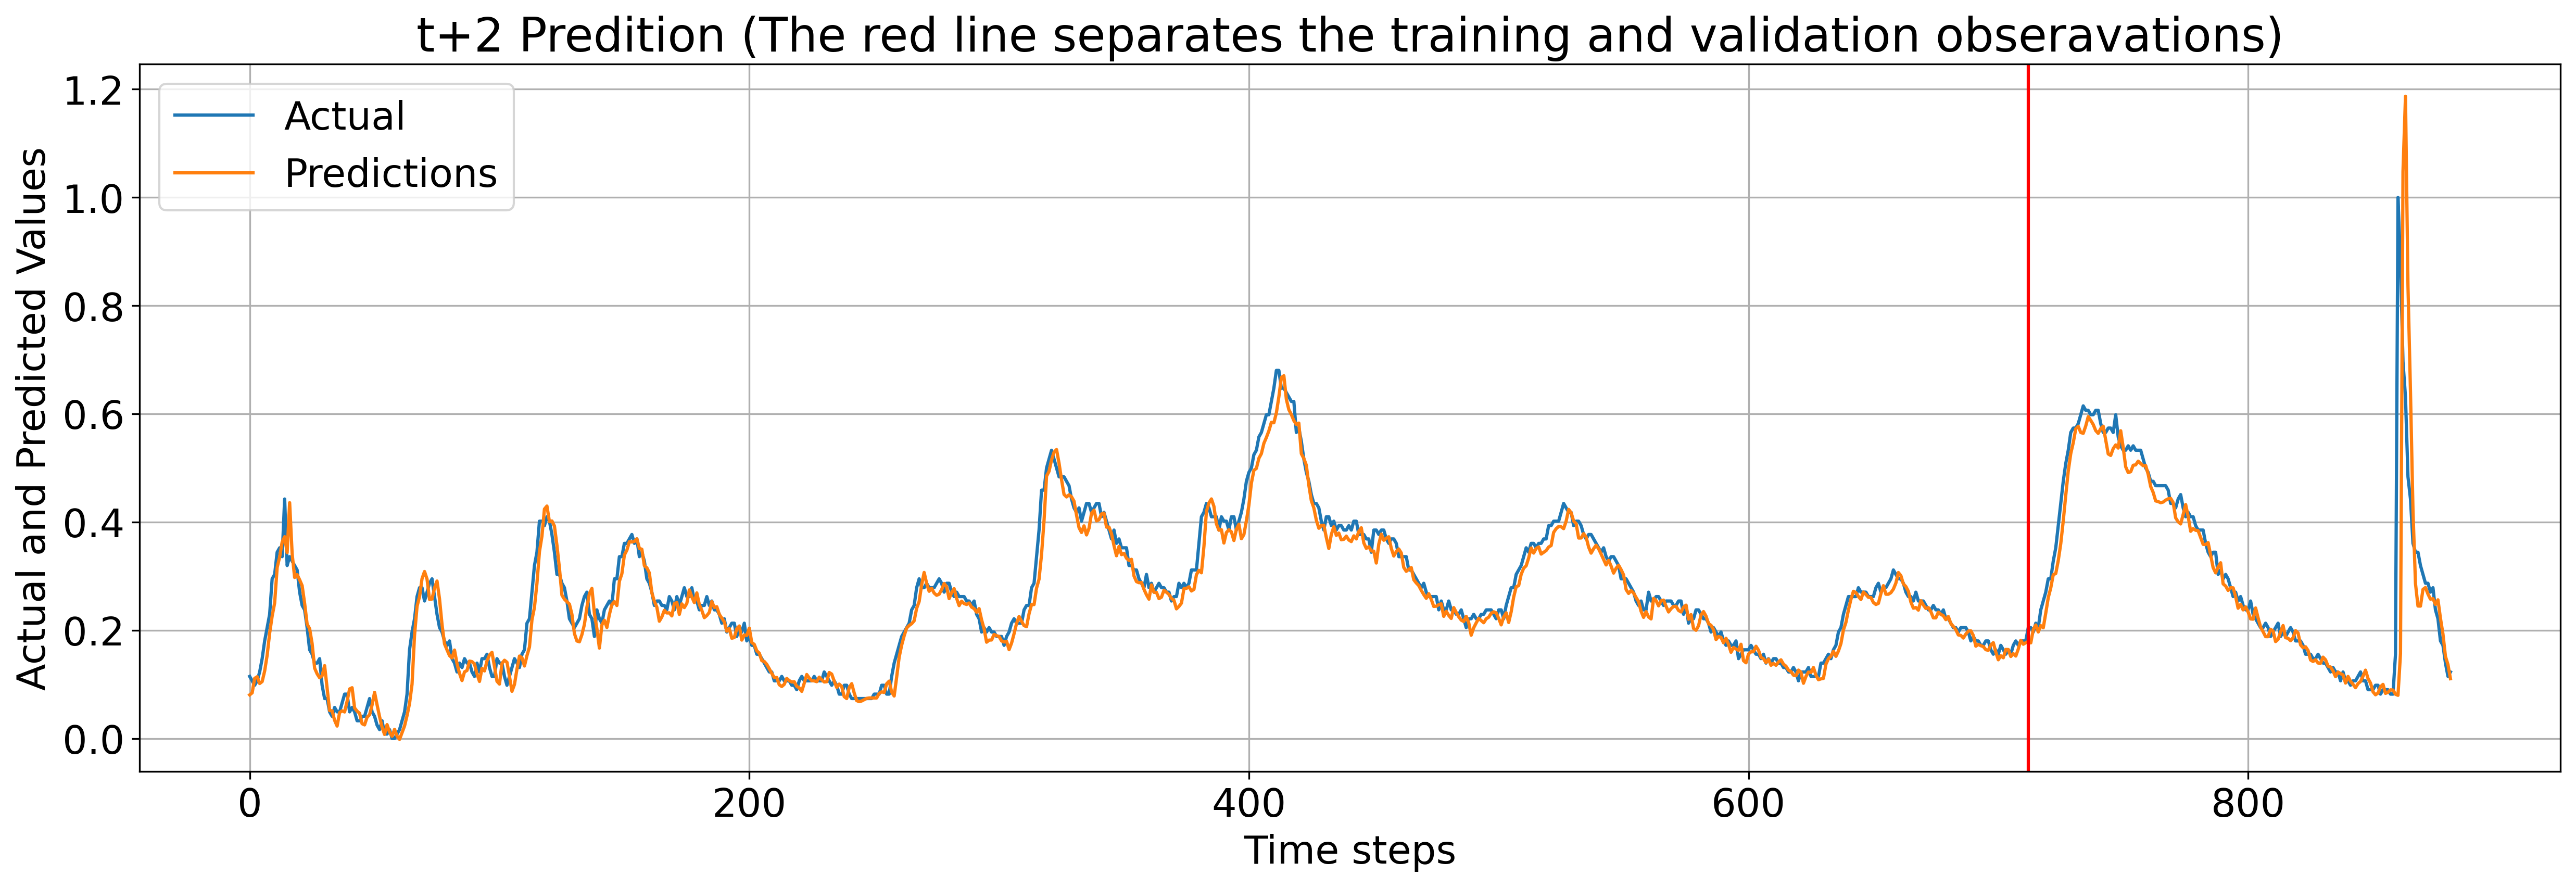

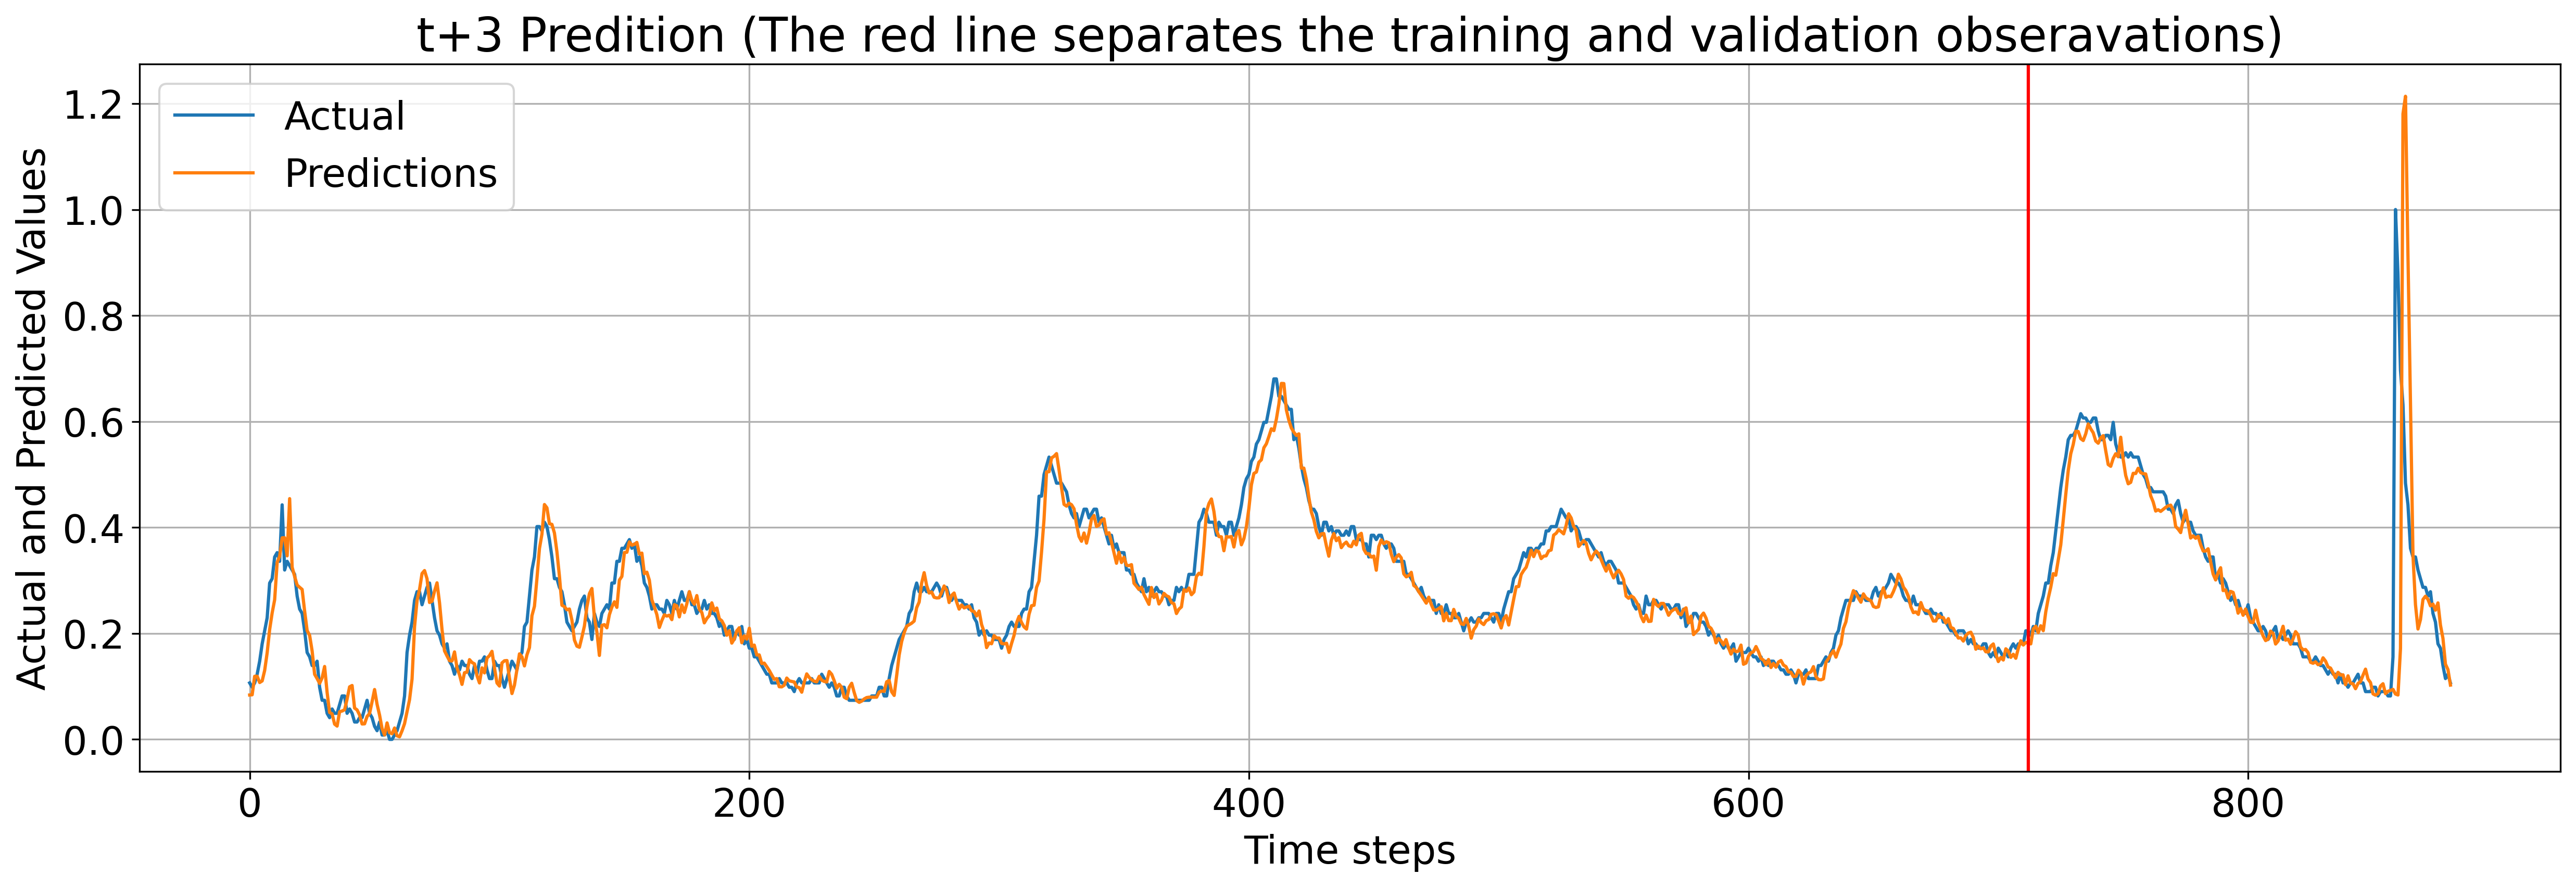

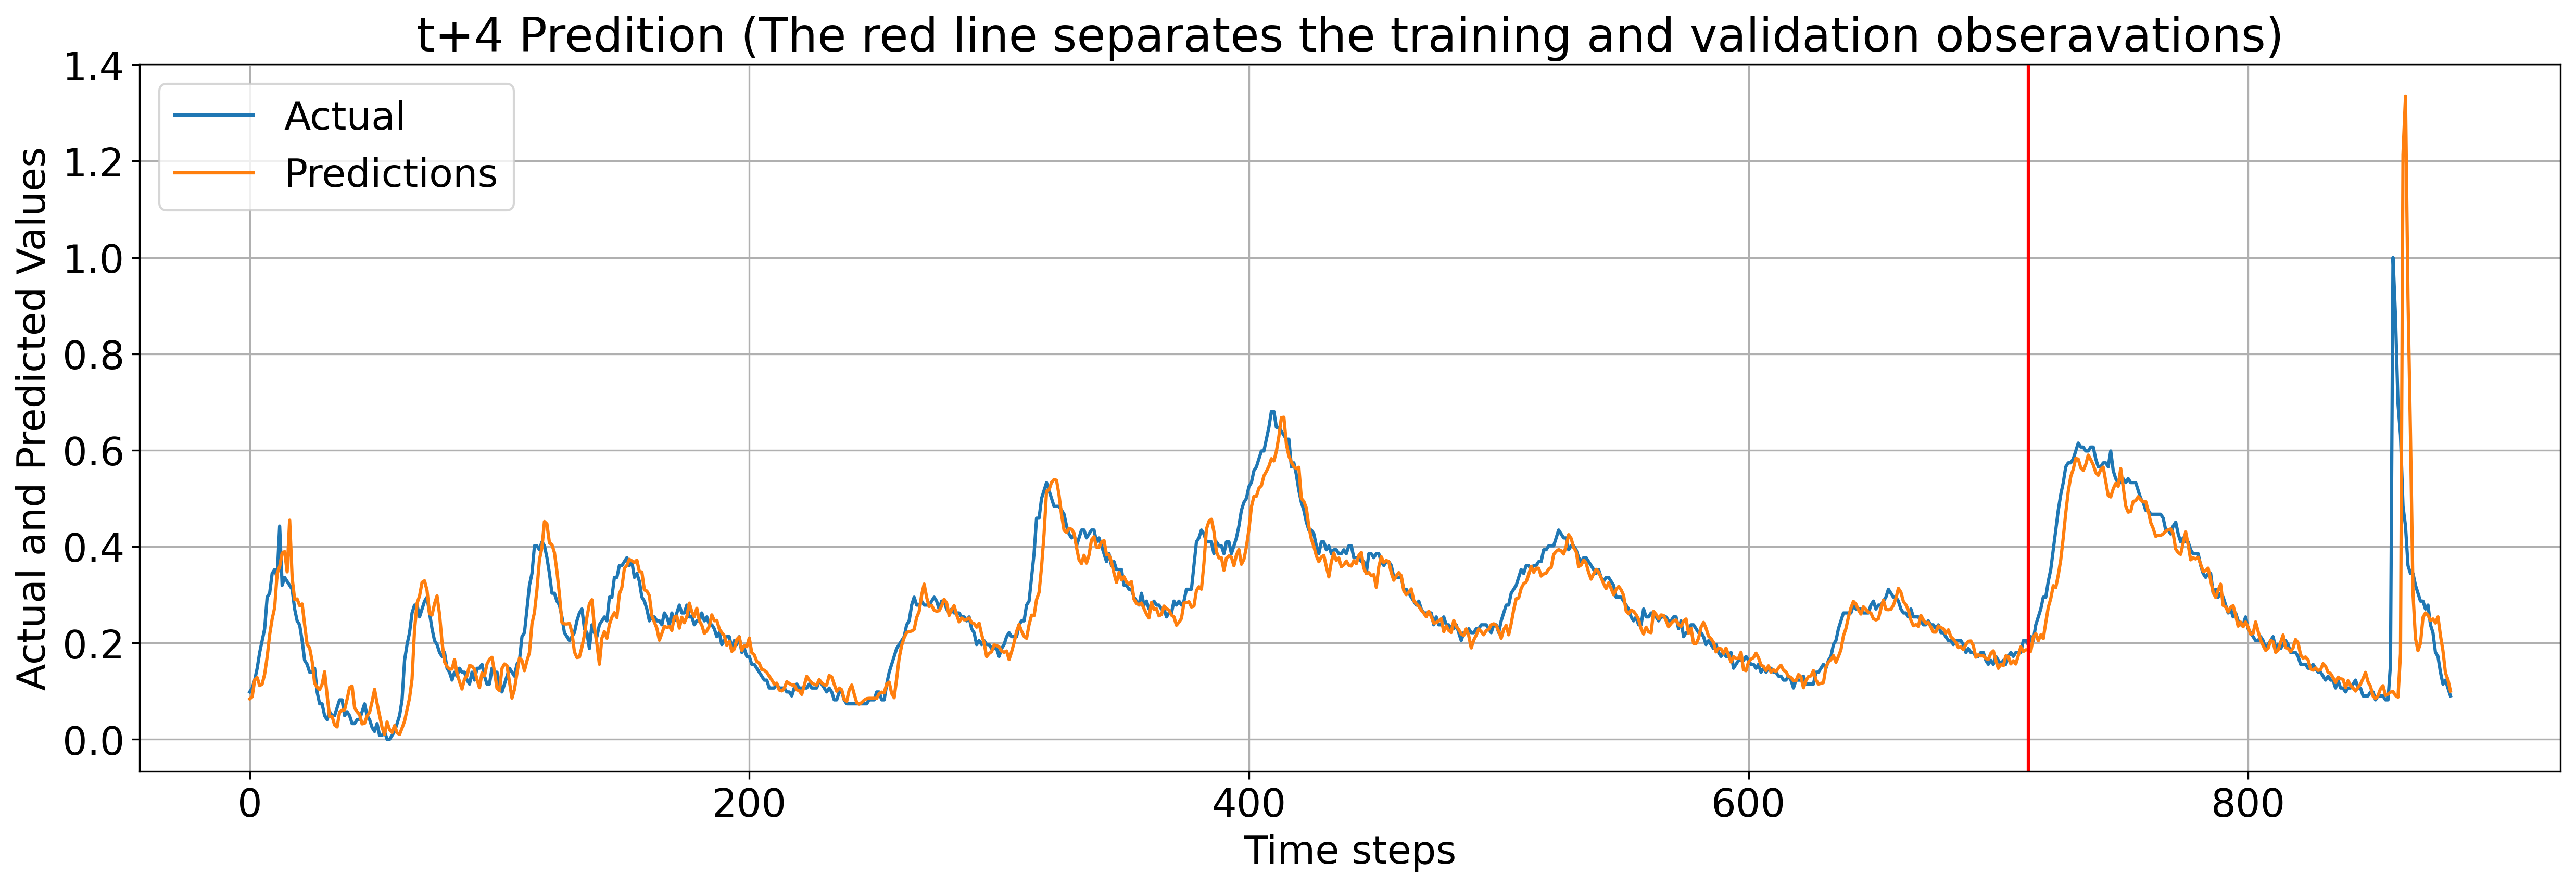

In [ ]:
# Plot the predictions together with the actual values
def plot_result(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(20, 6), dpi=300)
    plt.rcParams["font.size"] = "18"
    plt.plot(range(rows), actual)
    plt.plot(range(rows), predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.legend(['Actual', 'Predictions'])
    plt.xlabel('Time steps')
    plt.ylabel('Actual and Predicted Values')
    plt.title('t+%d Predition (The red line separates the training and validation obseravations)' % (i+1))
    plt.grid(True)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  plot_result(y1, y1_t, y1_pred, y1_pred_t,i)

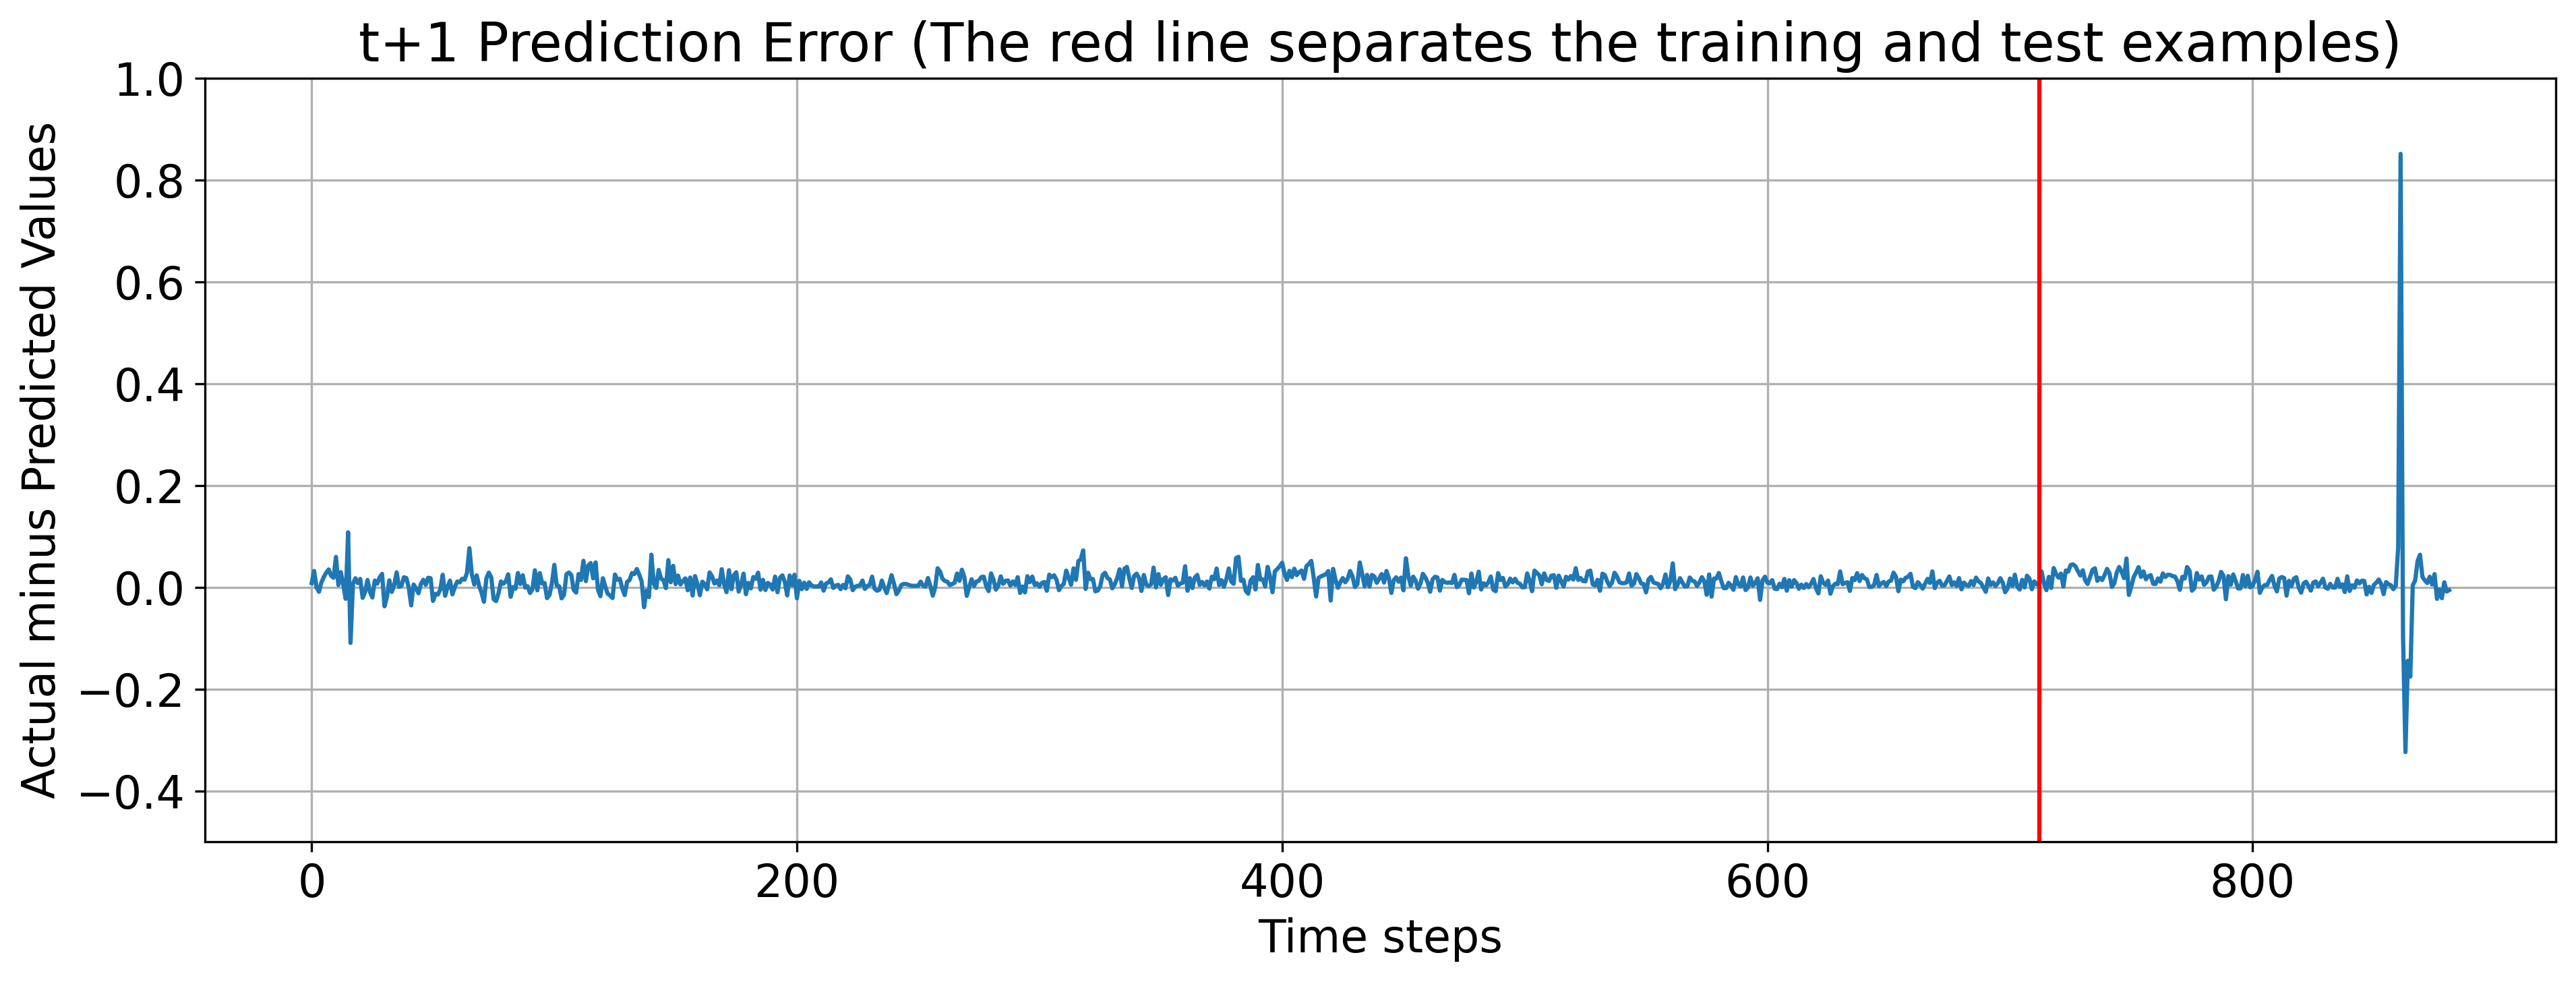

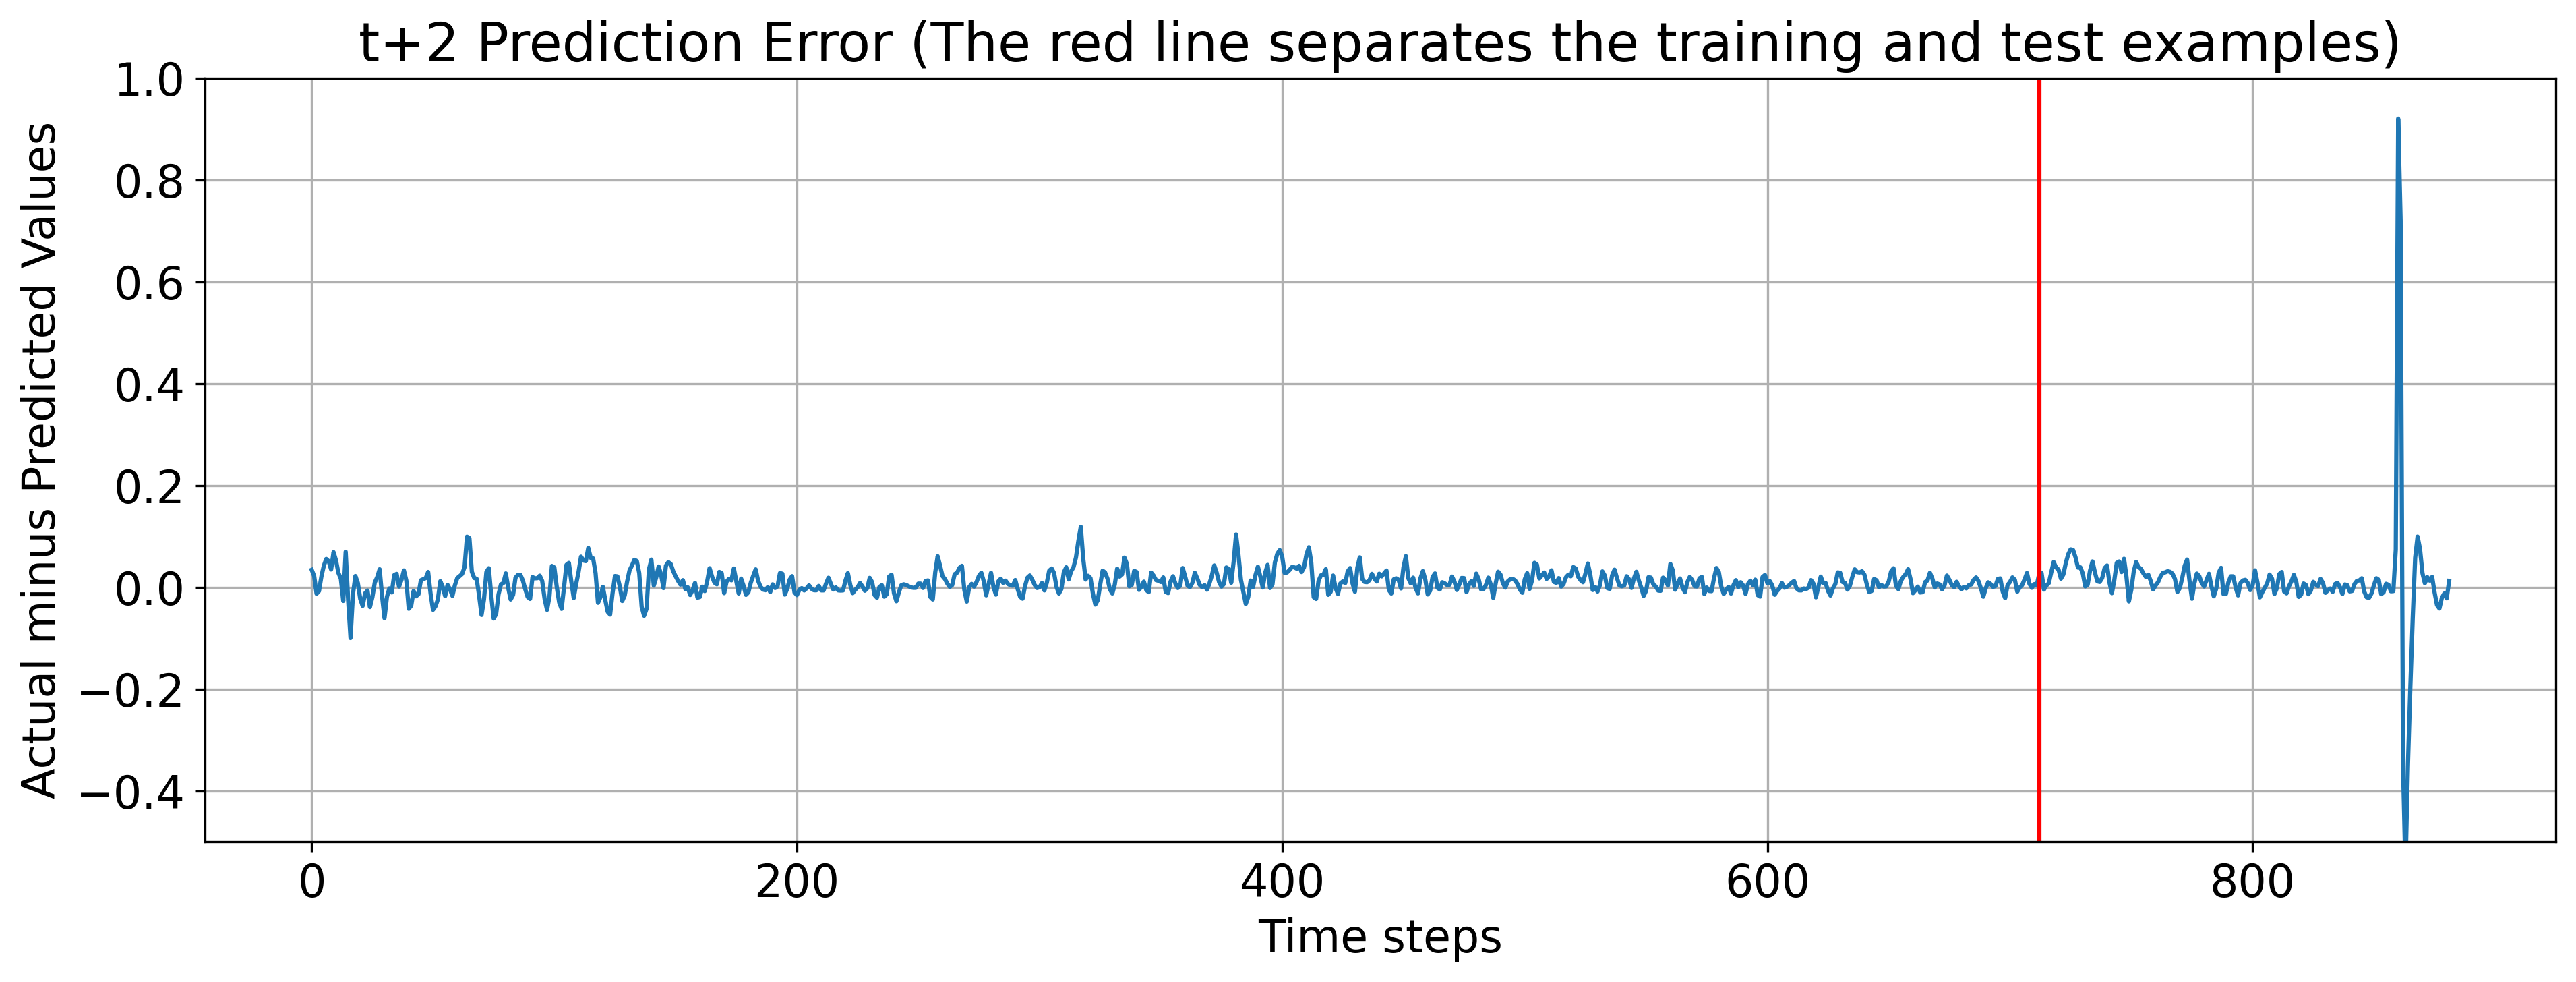

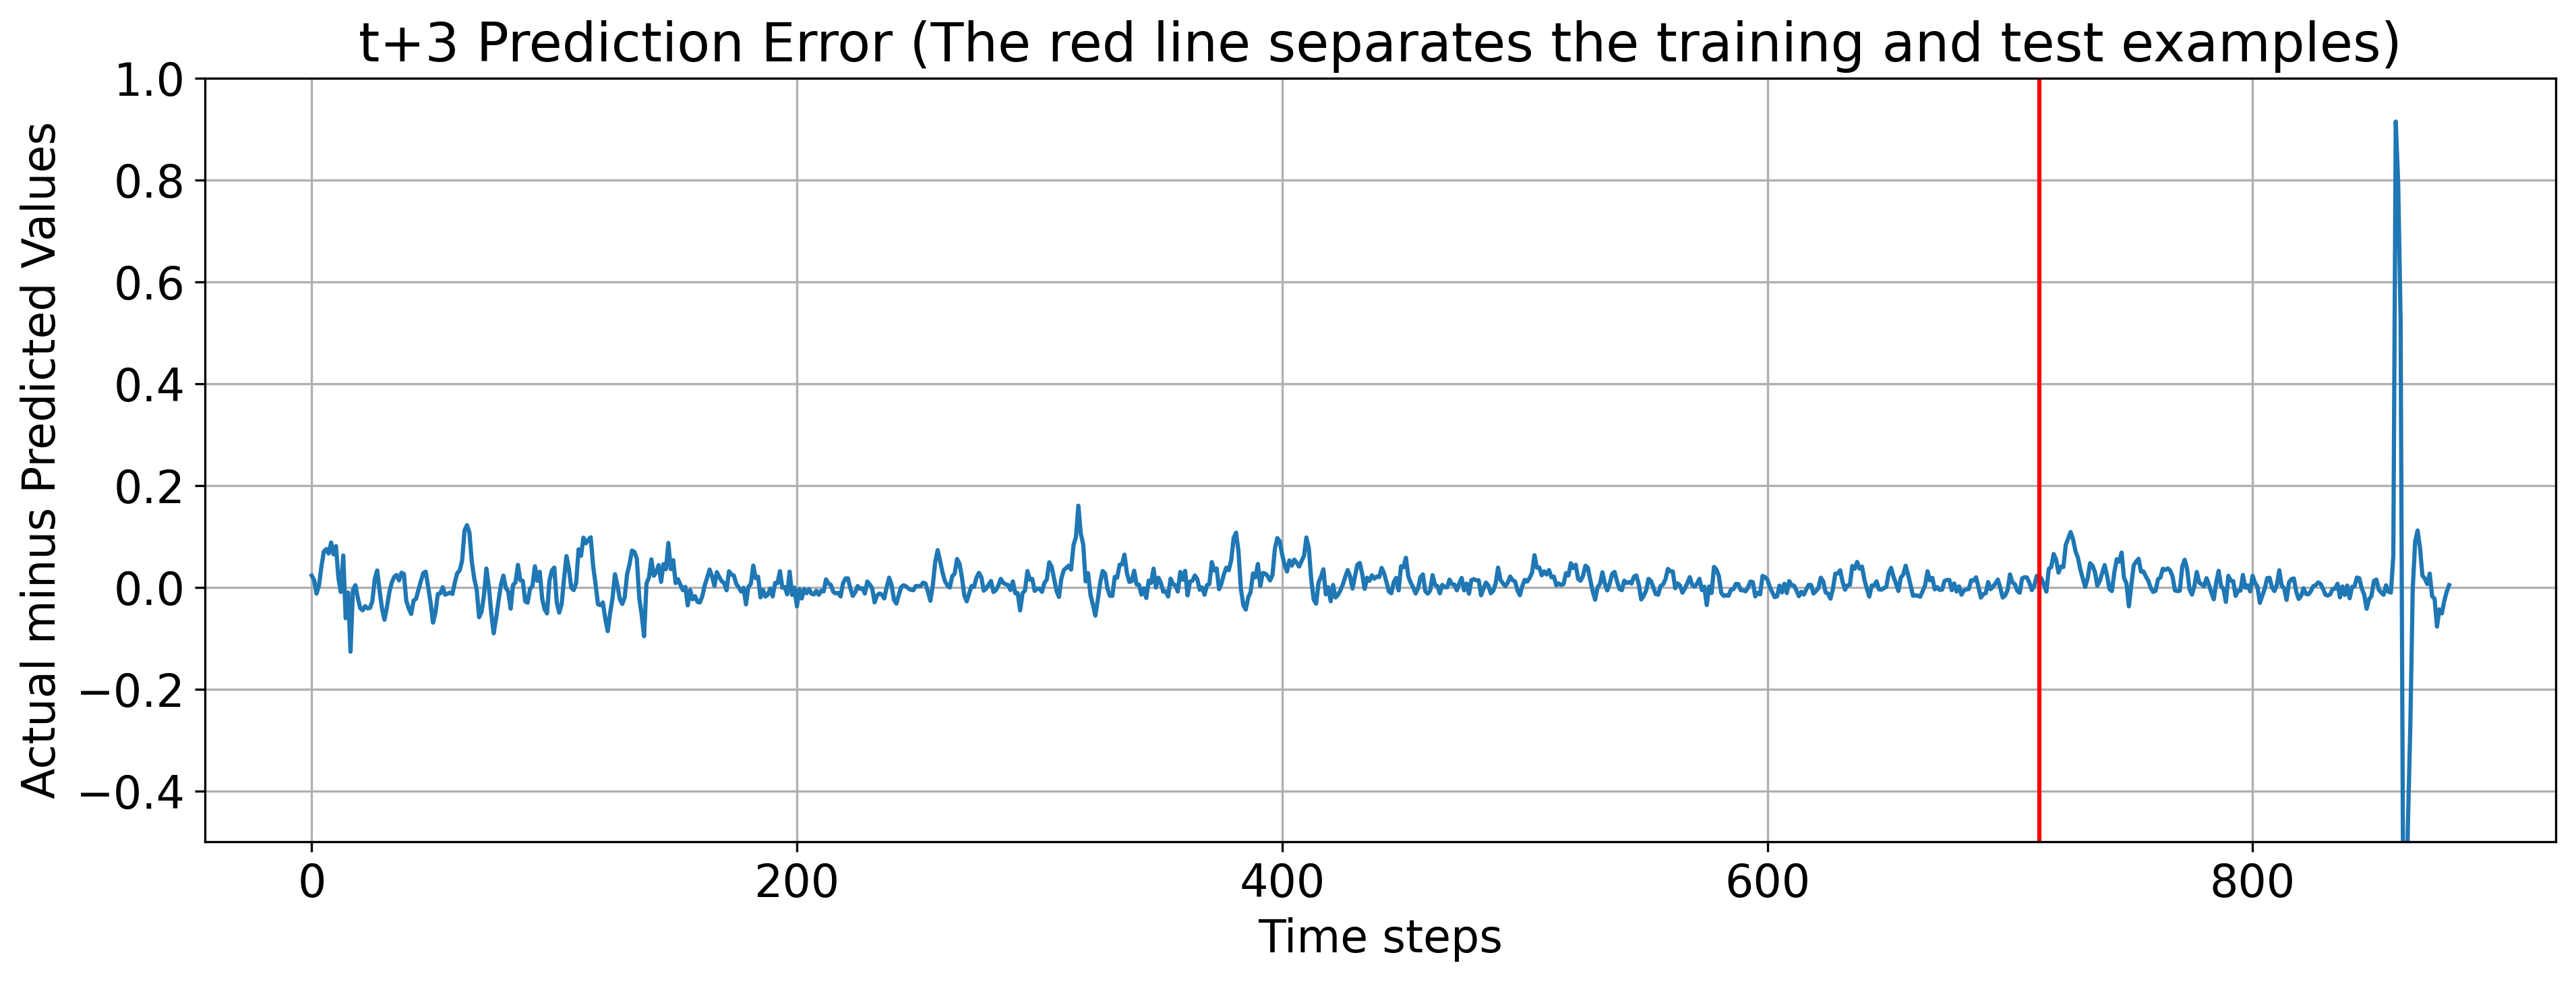

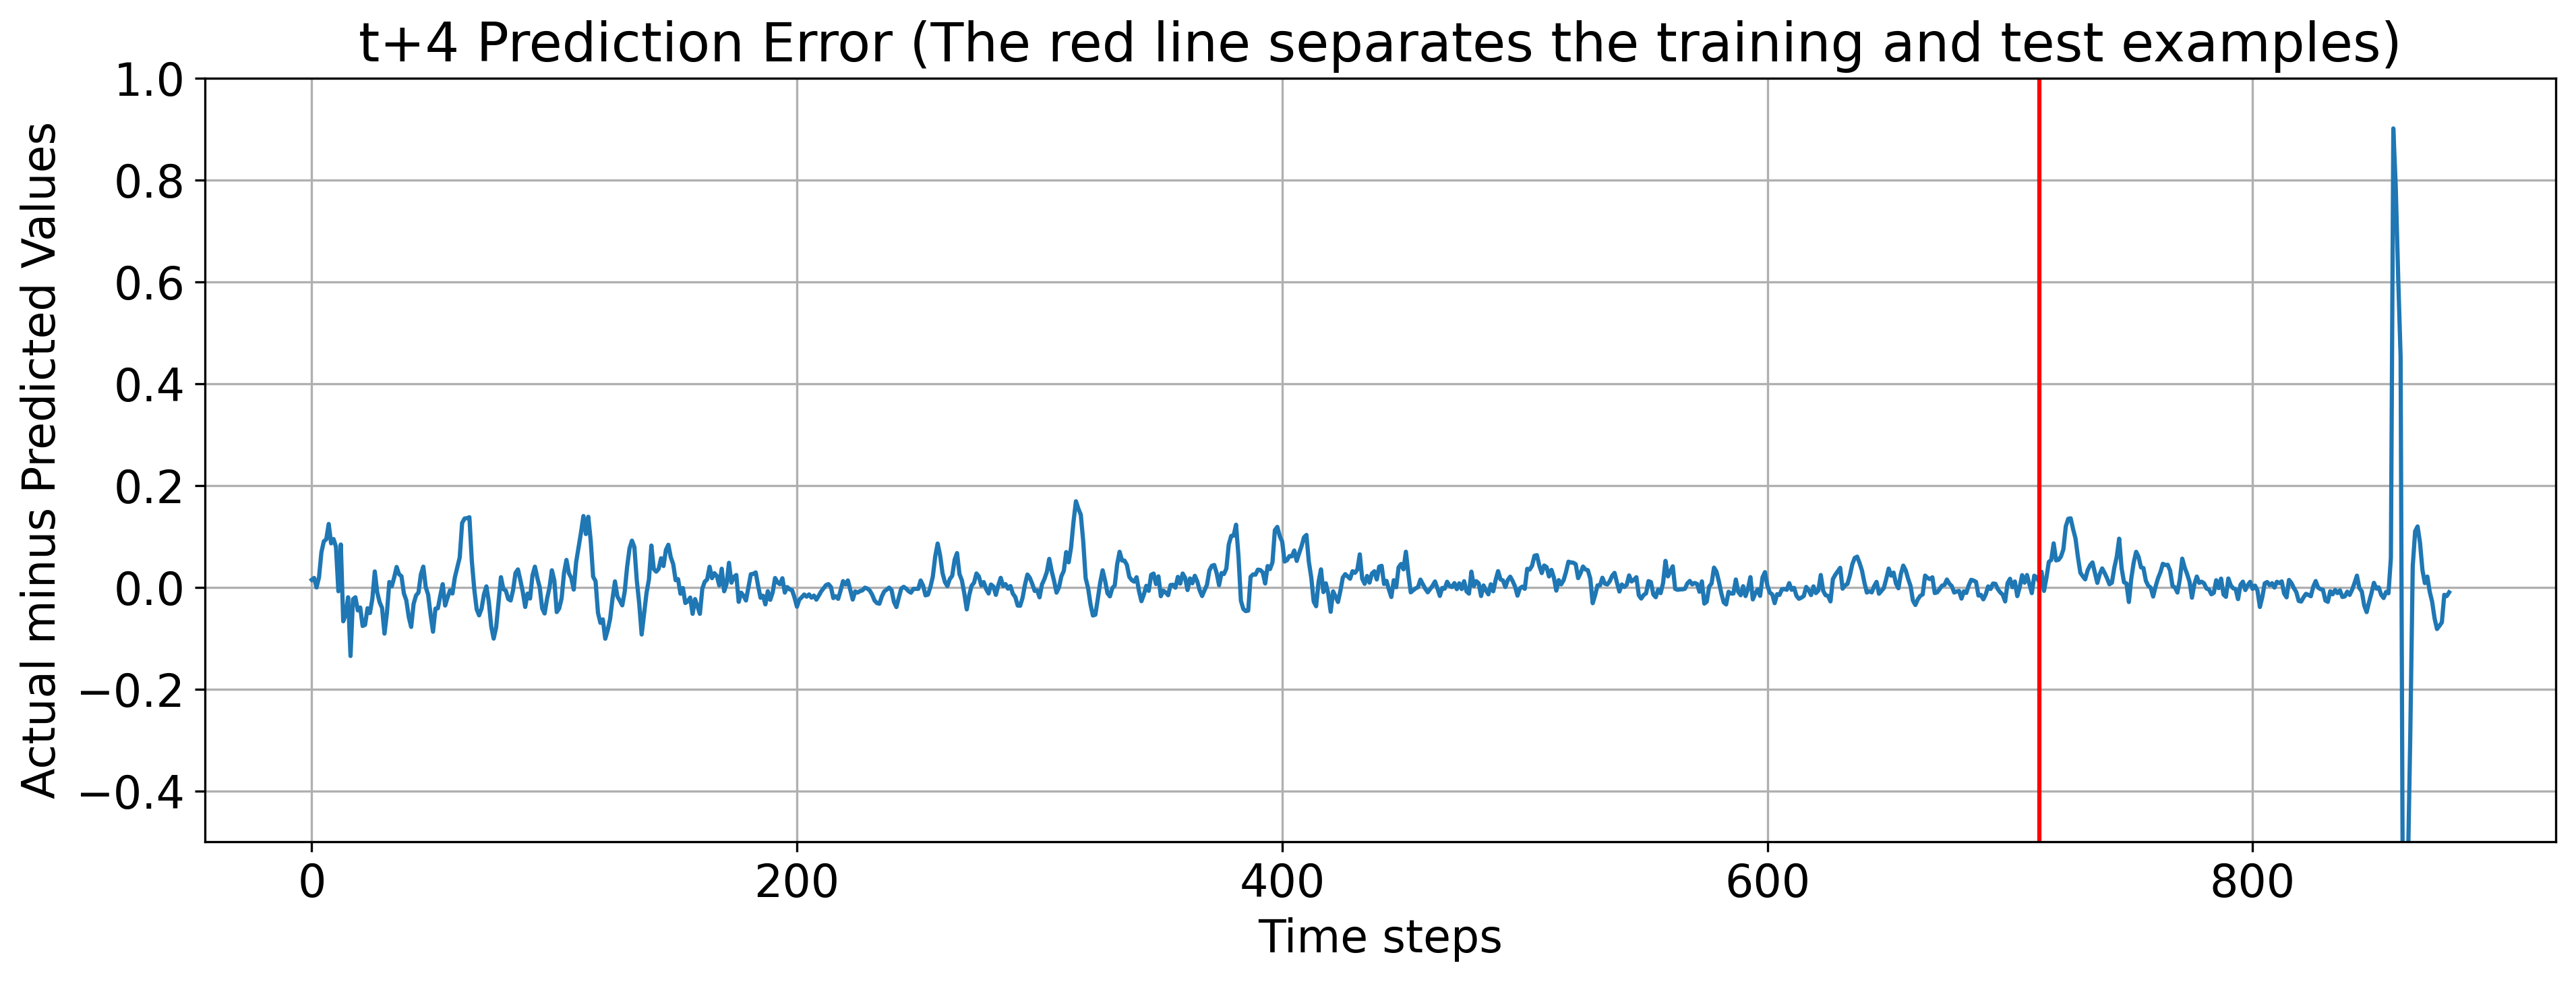

In [ ]:
# Plot the prediction error
def plot_result2(trainY, testY, train_predict, test_predict,i):
    actual = np.append(trainY, testY)
    predictions = np.append(train_predict, test_predict)
    rows = len(actual)
    plt.figure(figsize=(15, 5), dpi=300)
    plt.rcParams["font.size"] = "16"
    plt.plot(range(rows), actual - predictions)
    plt.axvline(x=len(trainY), color='r')
    plt.xlabel('Time steps')
    plt.ylabel('Actual minus Predicted Values')
    plt.title('t+%d Prediction Error (The red line separates the training and test examples)' % (i+1))
    plt.ylim(-0.5, +1.0) # Please, set the interval appropriately, considering all the graphs.
    plt.grid(True)

for i in range(horizon):
  if(horizon == 1):
    y1_pred = train_predict
    y1_pred_t = test_predict
    y1 = y
    y1_t = yt
  elif(horizon > 1):
    y1_pred = train_predict[:,i]
    y1_pred_t = test_predict[:,i]
    y1 = y[:,i]
    y1_t = yt[:,i]
  plot_result2(y1, y1_t, y1_pred, y1_pred_t,i)

In [ ]:
# Meaningful only for the simple RNN model (not for MLP or ESN)
wx = model.get_weights()[0]
wh = model.get_weights()[1]
bh = model.get_weights()[2]
wy = model.get_weights()[3]
by = model.get_weights()[4]
print(wx.shape)
print(wh.shape)
print(bh.shape)
print(wy.shape)
print(by.shape)

(1, 30)
(30, 30)
(30,)
(30, 3)
(3,)
